In [5]:
# Import necessary libraries
import pandas as pd
import sys
sys.path.append('../scripts')

from mongo_connection import get_matches_collection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Fetch the data
collection = get_matches_collection()
matches = pd.DataFrame(list(collection.find()))

# Display the first few rows and the columns of the dataframe
print(matches.head())
print(matches.columns)



                        _id       date home_team away_team  home_score  \
0  6692ad7288365a953ad9e558 1872-11-30  Scotland   England           0   
1  6692ad7288365a953ad9e559 1873-03-08   England  Scotland           4   
2  6692ad7288365a953ad9e55a 1874-03-07  Scotland   England           2   
3  6692ad7288365a953ad9e55b 1875-03-06   England  Scotland           2   
4  6692ad7288365a953ad9e55c 1876-03-04  Scotland   England           3   

   away_score tournament     city   country  neutral    winner  
0           0   Friendly  Glasgow  Scotland    False      Draw  
1           2   Friendly   London   England    False   England  
2           1   Friendly  Glasgow  Scotland    False  Scotland  
3           2   Friendly   London   England    False      Draw  
4           0   Friendly  Glasgow  Scotland    False  Scotland  
Index(['_id', 'date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'winner'],
      dtype='object')


In [6]:
# Drop irrelevant columns and handle missing values
matches.drop(columns=['_id', 'date', 'tournament', 'city', 'country', 'neutral'], inplace=True)
matches.dropna(inplace=True)

# Encode categorical variables (e.g., team names and winner)
matches = pd.get_dummies(matches, columns=['home_team', 'away_team', 'winner'], drop_first=True)

# Split the data into features (X) and target (y)
X = matches.drop(columns=[col for col in matches.columns if 'winner_' in col])
y = matches[[col for col in matches.columns if 'winner_' in col]]

# Flatten the target variable for logistic regression
y = y.idxmax(axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000, solver='lbfgs')
# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

In [9]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the model's output in the desired format
print(f"Accuracy: {accuracy:.6f}")
print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.596075
Classification Report:
                                         precision    recall  f1-score   support

                        winner_"Georgia       0.00      0.00      0.00         1
                        winner_Abkhazia       0.00      0.00      0.00         5
                     winner_Afghanistan       0.71      0.56      0.62         9
                         winner_Albania       0.60      0.60      0.60        25
                        winner_Alderney       0.00      0.00      0.00         1
                         winner_Algeria       0.50      0.52      0.51        46
                       winner_Andalusia       0.00      0.00      0.00         2
                         winner_Andorra       1.00      1.00      1.00         1
                          winner_Angola       0.62      0.64      0.63        28
                        winner_Anguilla       0.00      0.00      0.00         1
             winner_Antigua and Barbuda       0.59      0.50      

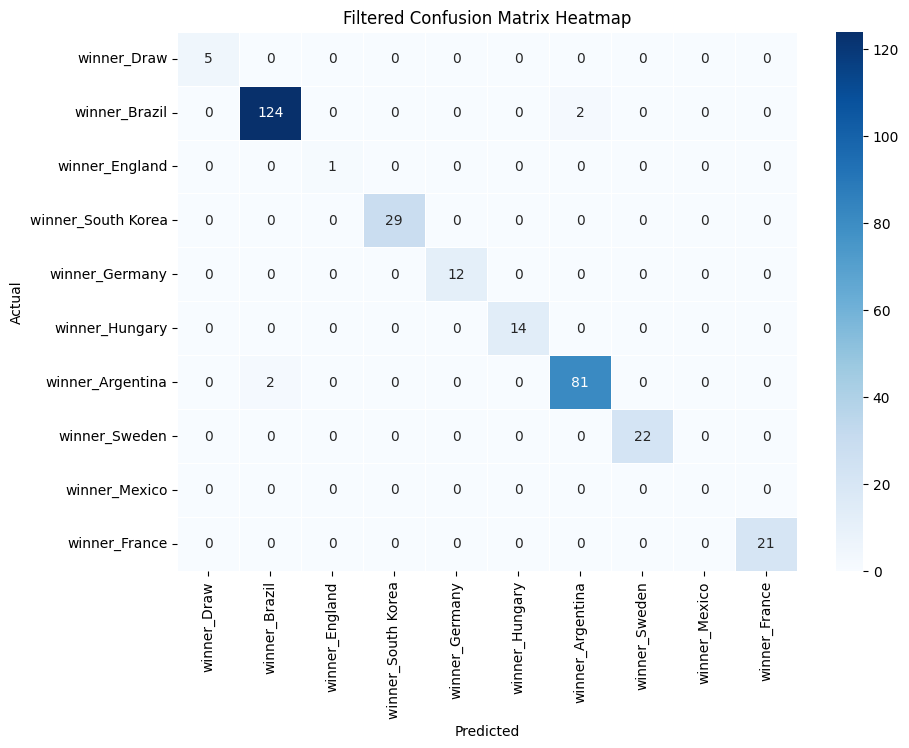

In [13]:
import numpy as np

# Calculate the frequency of each class in the test set
class_counts = y_test.value_counts()  # Get the frequency of each class

# Get the top N classes by frequency
top_n_classes = class_counts.index[:10]  # Adjust 10 to your preferred number
# Map the class labels to indices
class_to_index = {label: index for index, label in enumerate(np.unique(y_test))}

# Get the indices corresponding to the top N classes
top_n_indices = [class_to_index[class_name] for class_name in top_n_classes]

# Filter the confusion matrix to include only the top N classes
filtered_conf_matrix = conf_matrix[np.ix_(top_n_indices, top_n_indices)]

# Plot the filtered confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(filtered_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_n_classes, yticklabels=top_n_classes,
            linewidths=.5)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Filtered Confusion Matrix Heatmap')
plt.savefig('filtered_confusion_matrix_heatmap.png')
plt.show()

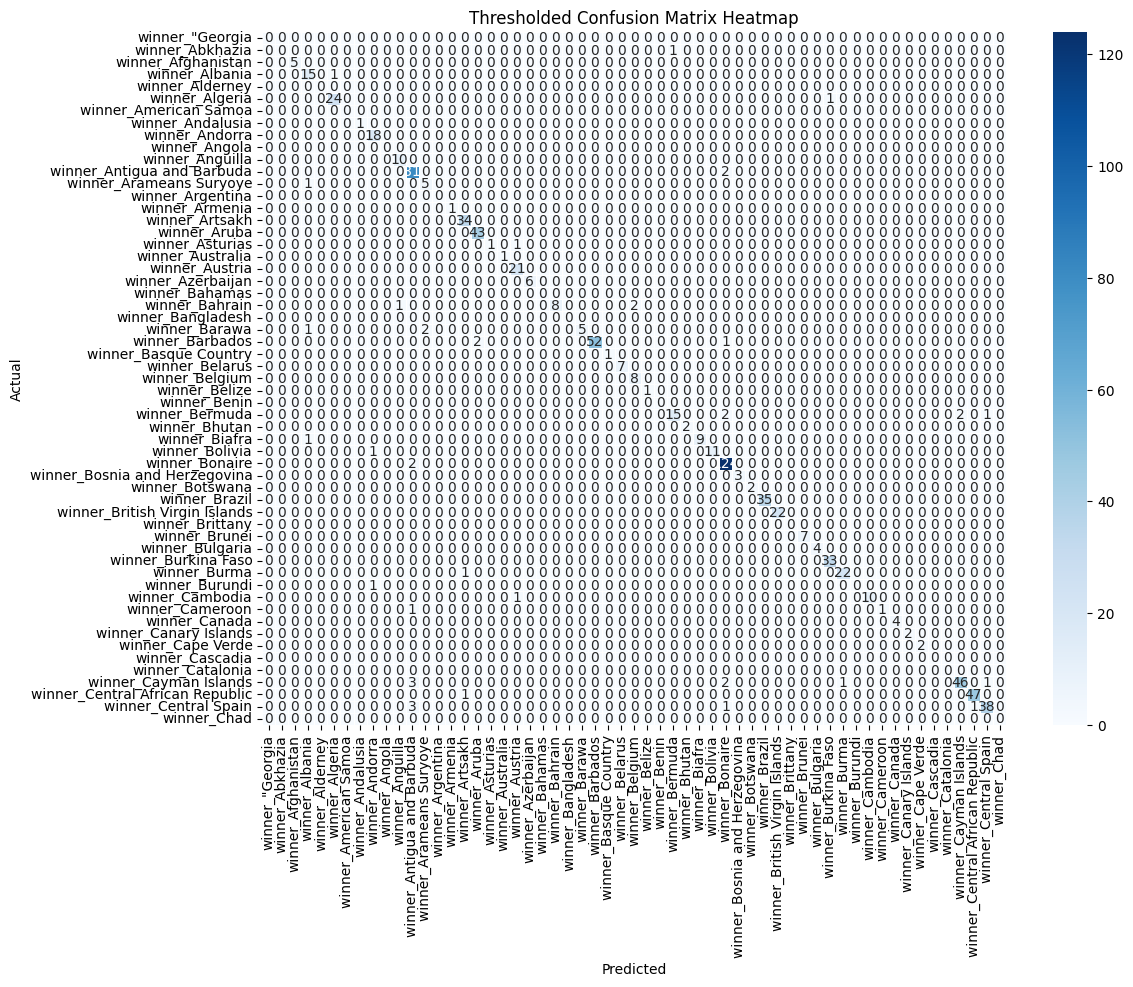

In [14]:
# Filter classes with more than a threshold number of occurrences
threshold = 50  # Adjust this threshold as needed
relevant_classes = [i for i, count in enumerate(class_counts) if count > threshold]

# Filter the confusion matrix
filtered_conf_matrix = conf_matrix[relevant_classes][:, relevant_classes]
filtered_class_labels = np.array(model.classes_)[relevant_classes]

# Plot the thresholded confusion matrix
plt.figure(figsize=(12, 9))
sns.heatmap(filtered_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=filtered_class_labels, yticklabels=filtered_class_labels,
            linewidths=.5)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Thresholded Confusion Matrix Heatmap')
plt.savefig('thresholded_confusion_matrix_heatmap.png')
plt.show()
